In [1]:
from kilosort import run_kilosort, DEFAULT_SETTINGS
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import gridspec, rcParams
# https://colab.research.google.com/github/mouseland/kilosort/blob/main/docs/tutorials/kilosort4.ipynb#scrollTo=MnOtna6Vlx8S

In [2]:
settings = DEFAULT_SETTINGS
scratch = '/home/lss72/palmer_scratch/spike_sort/'
filepath = scratch+'c24/c24_npx_raw.bin'
N_SECS = 300
settings['data_dir'] = scratch
settings['n_chan_bin'] = 384
settings['tmax'] = N_SECS # secs
settings['probe_path'] = 'neuropixPhase3A_kilosortChanMap.mat'
ops, st, clu, tF, Wall, similar_templates, is_ref, est_contam_rate, kept_spikes = \
    run_kilosort(settings=settings, filename=filepath)

kilosort.run_kilosort: Kilosort version 4.0.25
kilosort.run_kilosort: Python version 3.9.21
kilosort.run_kilosort: ----------------------------------------
kilosort.run_kilosort: System information:
kilosort.run_kilosort: Linux-4.18.0-477.74.1.el8_8.x86_64-x86_64-with-glibc2.28 x86_64
kilosort.run_kilosort: x86_64
kilosort.run_kilosort: Using GPU for PyTorch computations. Specify `device` to change this.
kilosort.run_kilosort: Using CUDA device: NVIDIA A100-PCIE-40GB 39.50GB
kilosort.run_kilosort: ----------------------------------------
kilosort.run_kilosort: Sorting /home/lss72/palmer_scratch/spike_sort/c24/c24_npx_raw.bin
kilosort.run_kilosort: Interpreting binary file as default dtype='int16'. If data was saved in a different format, specify `data_dtype`.
kilosort.run_kilosort:  
kilosort.run_kilosort: Computing preprocessing variables.
kilosort.run_kilosort: ----------------------------------------
kilosort.run_kilosort: N samples: 9000000
kilosort.run_kilosort: N seconds: 300.0
k

In [4]:
# outputs saved to results_dir
results_dir = Path(settings['data_dir']).joinpath('c42/kilosort4')
ops = np.load(results_dir / 'ops.npy', allow_pickle=True).item()
camps = pd.read_csv(results_dir / 'cluster_Amplitude.tsv', sep='\t')['Amplitude'].values
contam_pct = pd.read_csv(results_dir / 'cluster_ContamPct.tsv', sep='\t')['ContamPct'].values
chan_map =  np.load(results_dir / 'channel_map.npy')
templates =  np.load(results_dir / 'templates.npy')
chan_best = (templates**2).sum(axis=1).argmax(axis=-1)
chan_best = chan_map[chan_best]
amplitudes = np.load(results_dir / 'amplitudes.npy')
st = np.load(results_dir / 'spike_times.npy')
clu = np.load(results_dir / 'spike_clusters.npy')
firing_rates = np.unique(clu, return_counts=True)[1] * 30000 / st.max()
dshift = ops['dshift']

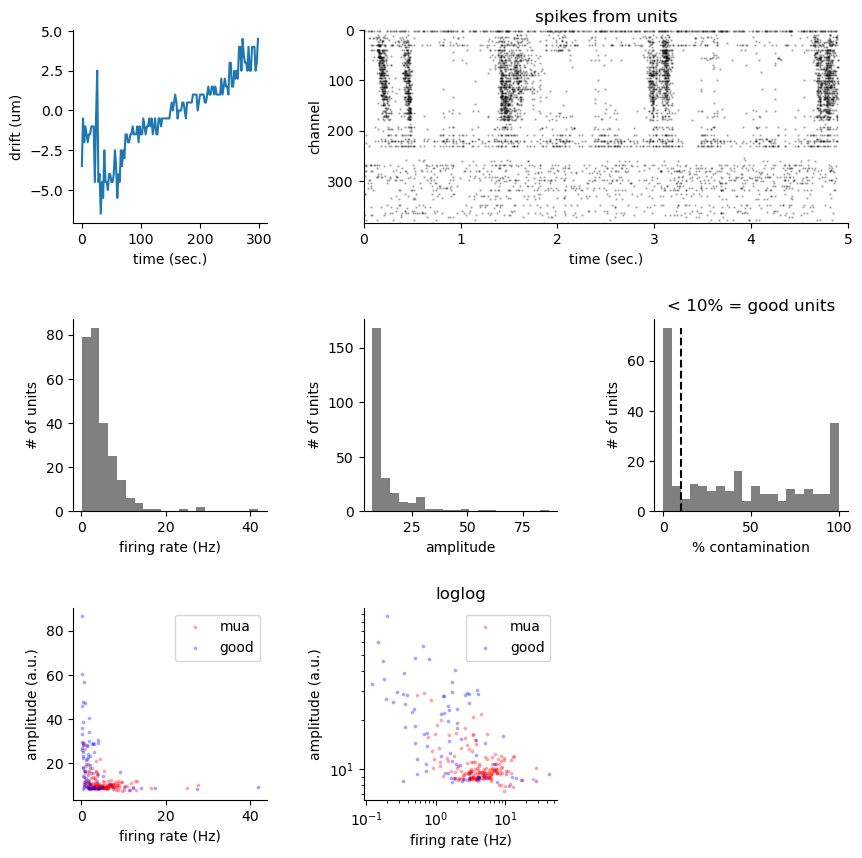

In [5]:
%matplotlib inline
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
gray = .5 * np.ones(3)

fig = plt.figure(figsize=(10,10), dpi=100)
grid = gridspec.GridSpec(3, 3, figure=fig, hspace=0.5, wspace=0.5)

ax = fig.add_subplot(grid[0,0])
ax.plot(np.arange(0, ops['Nbatches'])*2, dshift);
ax.set_xlabel('time (sec.)')
ax.set_ylabel('drift (um)')

ax = fig.add_subplot(grid[0,1:])
t0 = 0
t1 = np.nonzero(st > ops['fs']*4.9)[0][0]
ax.scatter(st[t0:t1]/30000., chan_best[clu[t0:t1]], s=0.5, color='k', alpha=0.25)
ax.set_xlim([0, 5])
ax.set_ylim([chan_map.max(), 0])
ax.set_xlabel('time (sec.)')
ax.set_ylabel('channel')
ax.set_title('spikes from units')

ax = fig.add_subplot(grid[1,0])
nb=ax.hist(firing_rates, 20, color=gray)
ax.set_xlabel('firing rate (Hz)')
ax.set_ylabel('# of units')

ax = fig.add_subplot(grid[1,1])
nb=ax.hist(camps, 20, color=gray)
ax.set_xlabel('amplitude')
ax.set_ylabel('# of units')

ax = fig.add_subplot(grid[1,2])
nb=ax.hist(np.minimum(100, contam_pct), np.arange(0,105,5), color=gray)
ax.plot([10, 10], [0, nb[0].max()], 'k--')
ax.set_xlabel('% contamination')
ax.set_ylabel('# of units')
ax.set_title('< 10% = good units')

for k in range(2):
    ax = fig.add_subplot(grid[2,k])
    is_ref = contam_pct<10.
    ax.scatter(firing_rates[~is_ref], camps[~is_ref], s=3, color='r', label='mua', alpha=0.25)
    ax.scatter(firing_rates[is_ref], camps[is_ref], s=3, color='b', label='good', alpha=0.25)
    ax.set_ylabel('amplitude (a.u.)')
    ax.set_xlabel('firing rate (Hz)')
    ax.legend()
    if k==1:
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_title('loglog')

fig.savefig(settings['data_dir']+"kilosort.png")